# Preprocessing

In [151]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [13]:
data = pd.read_csv("data/crimedata_csv_AllNeighbourhoods_AllYears.csv")
data.head()

,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
0,Break and Enter Commercial,2012,12,14,8,52,NaN,Oakridge,491285.0000,5.453433e+06
1,Break and Enter Commercial,2019,3,7,2,6,10XX SITKA SQ,Fairview,490612.9648,5.457110e+06
2,Break and Enter Commercial,2019,8,27,4,12,10XX ALBERNI ST,West End,491007.7798,5.459174e+06
3,Break and Enter Commercial,2021,4,26,4,44,10XX ALBERNI ST,West End,491007.7798,5.459174e+06
4,Break and Enter Commercial,2014,8,8,5,13,10XX ALBERNI ST,West End,491015.9434,5.459166e+06


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879861 entries, 0 to 879860
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TYPE           879861 non-null  object 
 1   YEAR           879861 non-null  int64  
 2   MONTH          879861 non-null  int64  
 3   DAY            879861 non-null  int64  
 4   HOUR           879861 non-null  int64  
 5   MINUTE         879861 non-null  int64  
 6   HUNDRED_BLOCK  879849 non-null  object 
 7   NEIGHBOURHOOD  879717 non-null  object 
 8   X              879785 non-null  float64
 9   Y              879785 non-null  float64
dtypes: float64(2), int64(5), object(3)
memory usage: 67.1+ MB


In [15]:
grouped = data.groupby(['TYPE', 'YEAR', 'MONTH']).size().reset_index(name='Observations')
grouped.head()

,TYPE,YEAR,MONTH,Observations
0,Break and Enter Commercial,2003,1,303
1,Break and Enter Commercial,2003,2,254
2,Break and Enter Commercial,2003,3,292
3,Break and Enter Commercial,2003,4,266
4,Break and Enter Commercial,2003,5,290


In [16]:
grouped['YEAR-MONTH'] = pd.to_datetime(grouped[['YEAR', 'MONTH']].assign(DAY=1))
grouped.head()

,TYPE,YEAR,MONTH,Observations,YEAR-MONTH
0,Break and Enter Commercial,2003,1,303,2003-01-01
1,Break and Enter Commercial,2003,2,254,2003-02-01
2,Break and Enter Commercial,2003,3,292,2003-03-01
3,Break and Enter Commercial,2003,4,266,2003-04-01
4,Break and Enter Commercial,2003,5,290,2003-05-01


In [17]:
grouped = grouped[~((grouped['YEAR'] == 2023) & (grouped['MONTH'] == 11))]
grouped

,TYPE,YEAR,MONTH,Observations,YEAR-MONTH
0,Break and Enter Commercial,2003,1,303,2003-01-01
1,Break and Enter Commercial,2003,2,254,2003-02-01
2,Break and Enter Commercial,2003,3,292,2003-03-01
3,Break and Enter Commercial,2003,4,266,2003-04-01
4,Break and Enter Commercial,2003,5,290,2003-05-01
...,...,...,...,...,...
2614,Vehicle Collision or Pedestrian Struck (with I...,2023,6,100,2023-06-01
2615,Vehicle Collision or Pedestrian Struck (with I...,2023,7,104,2023-07-01
2616,Vehicle Collision or Pedestrian Struck (with I...,2023,8,98,2023-08-01
2617,Vehicle Collision or Pedestrian Struck (with I...,2023,9,110,2023-09-01


In [23]:
data.TYPE.value_counts()

TYPE
Theft from Vehicle                                        243335
Other Theft                                               219751
Mischief                                                  107268
Offence Against a Person                                   76906
Break and Enter Residential/Other                          72543
Break and Enter Commercial                                 47836
Theft of Vehicle                                           44935
Theft of Bicycle                                           37293
Vehicle Collision or Pedestrian Struck (with Injury)       29319
Vehicle Collision or Pedestrian Struck (with Fatality)       359
Homicide                                                     316
Name: count, dtype: int64

In [24]:
theft_from_vehicle = grouped[grouped['TYPE']=='Theft from Vehicle']
theft_from_vehicle.head()

,TYPE,YEAR,MONTH,Observations,YEAR-MONTH
1433,Theft from Vehicle,2003,1,1438,2003-01-01
1434,Theft from Vehicle,2003,2,1102,2003-02-01
1435,Theft from Vehicle,2003,3,1251,2003-03-01
1436,Theft from Vehicle,2003,4,1528,2003-04-01
1437,Theft from Vehicle,2003,5,1873,2003-05-01


In [25]:
theft_from_vehicle.info()

<class 'pandas.core.frame.DataFrame'>
Index: 250 entries, 1433 to 1682
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   TYPE          250 non-null    object        
 1   YEAR          250 non-null    int64         
 2   MONTH         250 non-null    int64         
 3   Observations  250 non-null    int64         
 4   YEAR-MONTH    250 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 11.7+ KB


<Axes: xlabel='YEAR-MONTH', ylabel='Observations'>

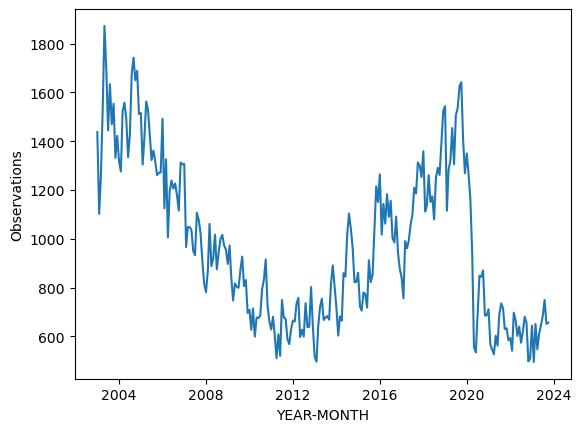

In [26]:
sns.lineplot(data=theft_from_vehicle, x='YEAR-MONTH', y='Observations')

In [ ]:
#grouped.to_csv('data/preprocessed_data.csv')

# Modelling

In [62]:
theft_from_vehicle_filtered = theft_from_vehicle[['YEAR-MONTH','Observations']]
theft_from_vehicle_filtered.set_index('YEAR-MONTH', inplace=True)
theft_from_vehicle_filtered.head()

,Observations
YEAR-MONTH,
2003-01-01,1438
2003-02-01,1102
2003-03-01,1251
2003-04-01,1528
2003-05-01,1873


## Simple Moving Average & Exponential Smoothing

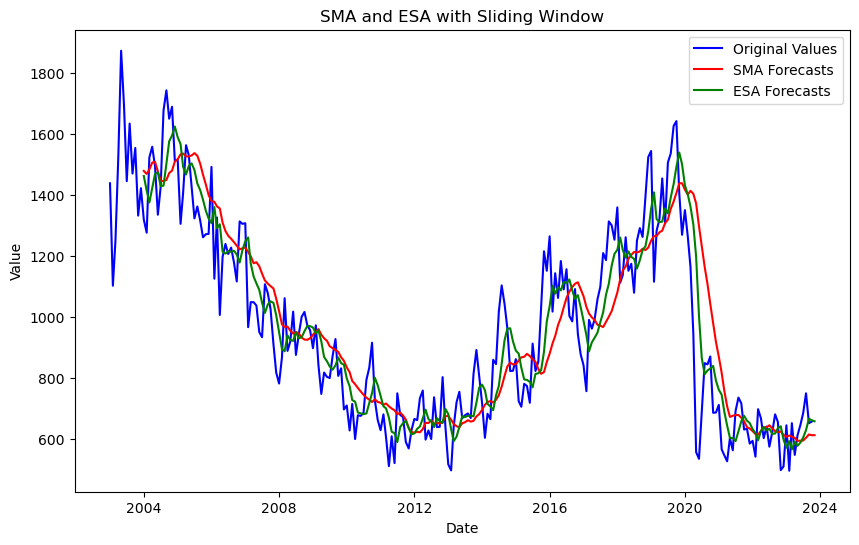

In [96]:
window_size = 12  # Define the size of the sliding window

# Perform Simple Moving Average (SMA) with a sliding window
sma_values = []
smoothed_values = []
for i in range(len(theft_from_vehicle_filtered) - window_size + 1):
    
    window = theft_from_vehicle_filtered['Observations'].iloc[i:i+window_size]
    
    window_mean = window.mean()
    sma_values.append(window_mean)

    smoothed_val = window.ewm(alpha=alpha, adjust=False).mean().iloc[-1]
    smoothed_values.append(smoothed_val)
    
new_date = pd.to_datetime('2023-11-01')
forecasted_dates = theft_from_vehicle_filtered.index[window_size:]
forecasted_dates = forecasted_dates.append(pd.DatetimeIndex([new_date]))

sma_forecasted = pd.DataFrame({'SMA_Forecast': sma_values}, index=forecasted_dates)
esa_forecasted = pd.DataFrame({'ESA_Forecast': smoothed_values}, index=forecasted_dates)

merged_df = pd.concat([theft_from_vehicle_filtered, sma_forecasted, esa_forecasted], axis=1)

# Plotting the line plot with the SMA values
plt.figure(figsize=(10, 6))
plt.plot(merged_df.index, merged_df['Observations'], label='Original Values', color='blue')
plt.plot(merged_df.index, merged_df['SMA_Forecast'], label='SMA Forecasts', color='red')
plt.plot(merged_df.index, merged_df['ESA_Forecast'], label='ESA Forecasts', color='green')
plt.legend()
plt.title('SMA and ESA with Sliding Window')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

## ARIMA

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

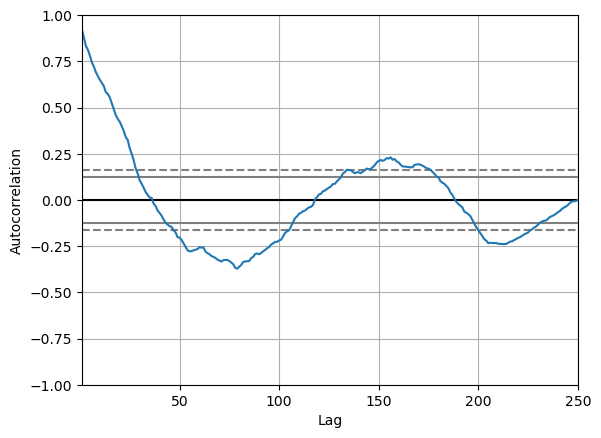

In [97]:
autocorrelation_plot(theft_from_vehicle.Observations)

In [98]:
df_diff = theft_from_vehicle_filtered.diff().dropna() 
autocorrelation_plot(df_diff.Observations)

,Observations
2003-02-01,-336.0
2003-03-01,149.0
2003-04-01,277.0
2003-05-01,345.0
2003-06-01,-178.0
...,...
2023-06-01,34.0
2023-07-01,39.0
2023-08-01,65.0
2023-09-01,-98.0


In [140]:
theft_from_vehicle_filtered.index = pd.DatetimeIndex(theft_from_vehicle_filtered.index.values, freq=theft_from_vehicle_filtered.index.inferred_freq)

window_size = 12  # Define the size of the rolling window

# Perform ARIMA forecast with a rolling window
forecasted_values = []
for i in range(len(theft_from_vehicle_filtered) - window_size + 1):
    
    window = theft_from_vehicle_filtered['Observations'].iloc[i:i+window_size+1]
    
    model = ARIMA(window, order=(4, 1, 0))  # Define ARIMA model (p=1, d=0, q=0)
    model_fit = model.fit()
    
    next_value = model_fit.forecast(steps=1).item()
    forecasted_values.append(next_value)

In [143]:
theft_from_vehicle_filtered

,Observations
2003-01-01,1438
2003-02-01,1102
2003-03-01,1251
2003-04-01,1528
2003-05-01,1873
...,...
2023-06-01,645
2023-07-01,684
2023-08-01,749
2023-09-01,651


In [141]:
new_date = pd.to_datetime('2023-11-01')
forecasted_dates = theft_from_vehicle_filtered.index[window_size:]
forecasted_dates = forecasted_dates.append(pd.DatetimeIndex([new_date]))

ARIMA_forecasted = pd.DataFrame({'ARIMA_Forecast': forecasted_values}, index=forecasted_dates)

,ARIMA_Forecast
2004-01-01,1430.669438
2004-02-01,1263.280608
2004-03-01,1477.978780
2004-04-01,1444.719797
2004-05-01,1536.012760
...,...
2023-07-01,631.550408
2023-08-01,697.339737
2023-09-01,679.955980
2023-10-01,634.174521


In [145]:
merged_df = pd.concat([merged_df, ARIMA_forecasted], axis=1)
merged_df

,Observations,SMA_Forecast,ESA_Forecast,ARIMA_Forecast
2003-01-01,1438.0,NaN,NaN,NaN
2003-02-01,1102.0,NaN,NaN,NaN
2003-03-01,1251.0,NaN,NaN,NaN
2003-04-01,1528.0,NaN,NaN,NaN
2003-05-01,1873.0,NaN,NaN,NaN
...,...,...,...,...
2023-07-01,684.0,594.083333,603.749242,631.550408
2023-08-01,749.0,603.250000,628.475010,697.339737
2023-09-01,651.0,613.916667,665.449143,679.955980
2023-10-01,656.0,611.500000,660.768368,634.174521


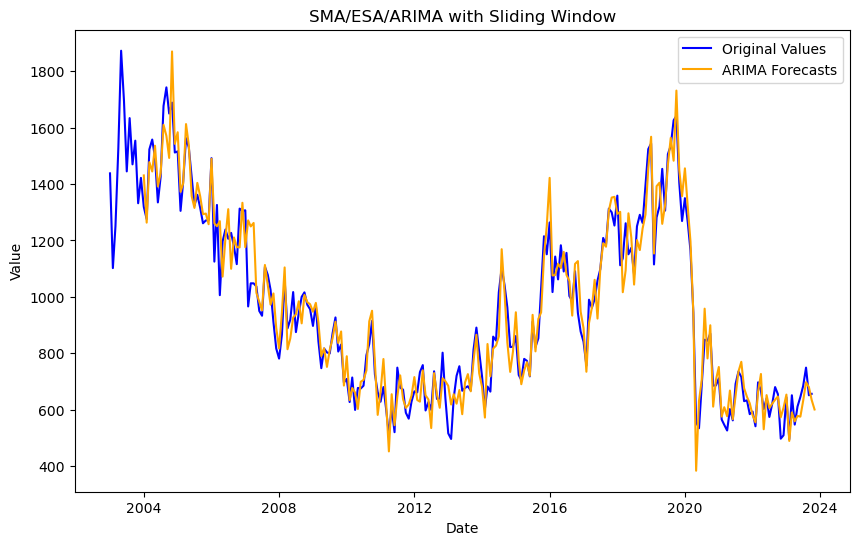

In [150]:
# Plotting the line plot with the SMA values
plt.figure(figsize=(10, 6))
plt.plot(merged_df.index, merged_df['Observations'], label='Original Values', color='blue')
plt.plot(merged_df.index, merged_df['ARIMA_Forecast'], label='ARIMA Forecasts', color='orange')
plt.legend()
plt.title('SMA/ESA/ARIMA with Sliding Window')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

In [155]:
merged_df_drop = merged_df.dropna()
merged_df_drop

,Observations,SMA_Forecast,ESA_Forecast,ARIMA_Forecast
2004-01-01,1319.0,1478.666667,1462.018909,1430.669438
2004-02-01,1276.0,1468.750000,1414.462564,1263.280608
2004-03-01,1523.0,1483.250000,1374.986147,1477.978780
2004-04-01,1558.0,1505.916667,1423.224339,1444.719797
2004-05-01,1494.0,1508.416667,1468.432282,1536.012760
...,...,...,...,...
2023-06-01,645.0,593.666667,587.375381,575.176424
2023-07-01,684.0,594.083333,603.749242,631.550408
2023-08-01,749.0,603.250000,628.475010,697.339737
2023-09-01,651.0,613.916667,665.449143,679.955980


In [157]:
# List to store MAE and MSE results
mae_values = []
mse_values = []

# Calculate MAE and MSE for each forecast column compared to the original column
for col in merged_df_drop.columns[1:]:  # Loop through forecast columns (excluding the original column)
    mae = mean_absolute_error(merged_df_drop['Observations'], merged_df_drop[col])
    mse = mean_squared_error(merged_df_drop['Observations'], merged_df_drop[col])
    mae_values.append(mae)
    mse_values.append(mse)

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Forecast_Column': merged_df_drop.columns[1:],  # Column names of forecasted values
    'MAE': mae_values,
    'MSE': mse_values
})

results_df

,Forecast_Column,MAE,MSE
0,SMA_Forecast,121.216737,27239.951827
1,ESA_Forecast,98.641493,16240.436389
2,ARIMA_Forecast,59.279707,5970.333891
